In [7]:
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,7)


def likelihood(theta, n, x):
    """
    likelihood function for a binomial distribution

    n: [int] the number of experiments
    x: [int] the number of successes
    theta: [float] the proposed probability of success
    """
    return (factorial(n) / (factorial(x) * factorial(n - x))) \
            * (theta ** x) * ((1 - theta) ** (n - x))

#the number of impressions for our facebook-yellow-dress campaign
n_impressions = 10.                                             
                                                               
#the number of clicks for our facebook-yellow-dress campaign
n_clicks = 7.                                                  

#observed click through rate
ctr = n_clicks / n_impressions                                 

#0 to 1, all possible click through rates
possible_theta_values = list(map(lambda x: x/100., range(100)))
                                                               
#evaluate the likelihood function for possible click through rates
likelihoods = list(map(lambda theta: likelihood(theta, n_impressions, n_clicks)\
                                , possible_theta_values))

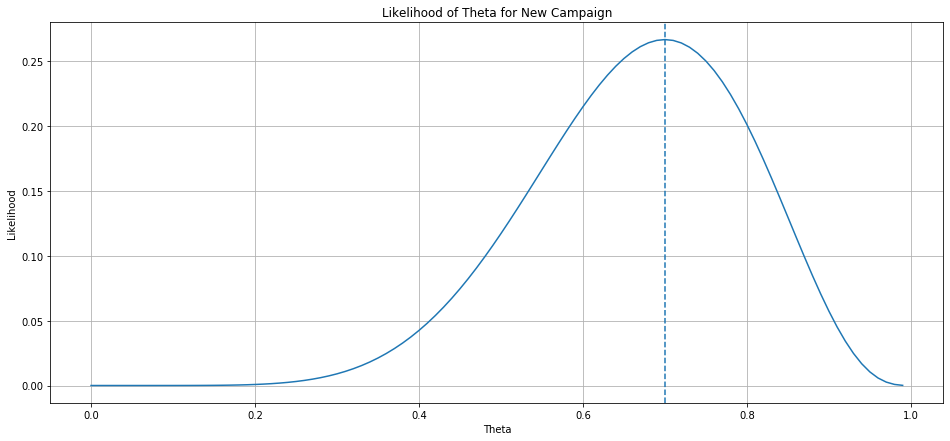

In [8]:
#pick the best theta
mle = possible_theta_values[np.argmax(likelihoods)]

#plot
f, ax = plt.subplots(1)          
ax.plot(possible_theta_values, likelihoods)
ax.axvline(mle, linestyle = "--")
ax.set_xlabel("Theta")
ax.set_ylabel("Likelihood")
ax.grid()
ax.set_title("Likelihood of Theta for New Campaign")
plt.show()

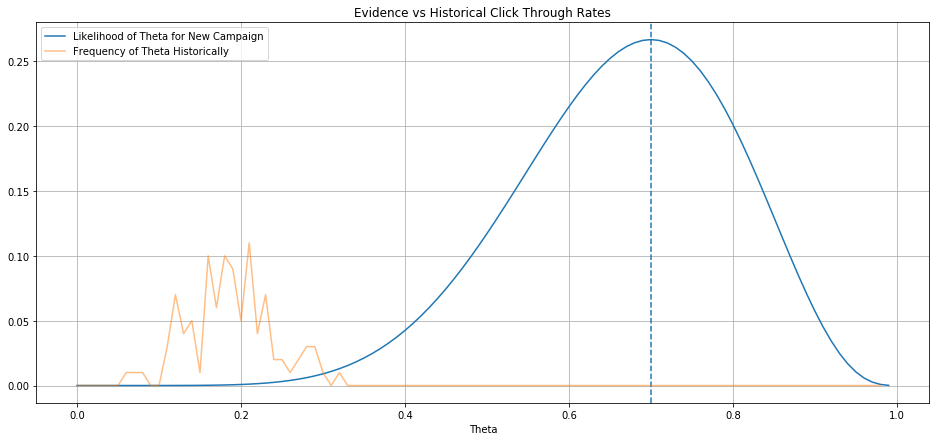

In [10]:
plt.rcParams['figure.figsize'] = (16, 7)
import numpy as np
import pandas as pd

true_a = 11.5
true_b = 48.5

#number of marketing campaigns
N = 100

#randomly generate "true" click through rate for each campaign
p = np.random.beta(true_a,true_b, size=N)

#randomly pick the number of impressions for each campaign
impressions = np.random.randint(1, 10000, size=N)

#sample number of clicks for each campaign
clicks = np.random.binomial(impressions, p).astype(float)

click_through_rates = clicks / impressions

#plot the histogram of previous click through rates with the evidence
#of the new campaign
f, ax = plt.subplots(1)

ax.axvline(mle, linestyle = "--")
ax.plot(possible_theta_values, likelihoods)

zero_to_one = [j/100. for j in range(100)]
counts, bins = np.histogram(click_through_rates
                            , bins=zero_to_one)
counts = counts / 100.
ax.plot(bins[:-1],counts, alpha = .5)
line1, line2, line3 = ax.lines
ax.legend((line2, line3), ('Likelihood of Theta for New Campaign'
                           , 'Frequency of Theta Historically')
                          , loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid()
ax.set_title("Evidence vs Historical Click Through Rates")
plt.show()

In [ ]:
from scipy.stats import beta

#fit beta to previous CTRs
prior_parameters = beta.fit(click_through_rates
                            , floc = 0
                            , fscale = 1)
#extract a,b from fit
prior_a, prior_b = prior_parameters[0:2]

#define prior distribution sample from prior
prior_distribution = beta(prior_a, prior_b)
#get histogram of samples
prior_samples = prior_distribution.rvs(10000)
#get histogram of samples
fit_counts, bins = np.histogram(prior_samples
                                , zero_to_one)
#normalize histogram
fit_counts = list(map(lambda x: float(x)/fit_counts.sum()
                         , fit_counts))

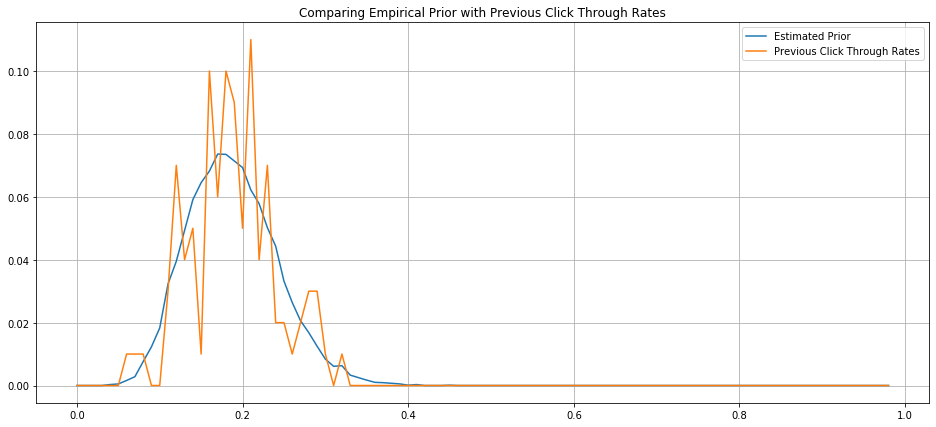

In [12]:
#plot
f, ax = plt.subplots(1)
ax.plot(bins[:-1], fit_counts)

hist_ctr, bins = np.histogram(click_through_rates
                              , zero_to_one)
hist_ctr = list(map(lambda x: float(x)/hist_ctr.sum()
                              , hist_ctr))
ax.plot(bins[:-1], hist_ctr)
estimated_prior, previous_click_through_rates = ax.lines
ax.legend((estimated_prior, previous_click_through_rates)
          ,('Estimated Prior'
            , 'Previous Click Through Rates'))
ax.grid()
ax.set_title("Comparing Empirical Prior with Previous Click Through Rates")
plt.show()

Doing Bayesian Inference with PyMC
Usually, the true posterior must be approximated with numerical methods. To see why, let's return to the definition of the posterior distribution:

$ p(\theta | X) = \frac{p(\theta) p(X | \theta)}{p(X)} $

The denominator p(X) is the total probability of observing our data under all possible values of θ. A more descriptive representation of this quantity is given by:

$\int p(\theta) p(X|\theta) d\theta$

Which sums the probability of X over all values of θ. This integral usually does not have a closed-form solution, so we need an approximation. One method of approximating our posterior is by using Markov Chain Monte Carlo (MCMC), which generates samples in a way that mimics the unknown distribution. We begin at a particular value, and "propose" another value as a sample according to a stochastic process. We may reject the sample if the proposed value seems unlikely and propose another. If we accept the proposal, we move to the new value and propose another.

PyMC is a python package for building arbitrary probability models and obtaining samples from the posterior distributions of unknown variables given the model. In our example, we'll use MCMC to obtain the samples.

The prototypical PyMC program has two components:

Define all variables, and how variables depend on each other

Run an algorithm to simulate a posterior distribution

Let's now obtain samples from the posterior. We select our prior as a Beta(11.5,48.5). Let's see how observing 7 clicks from 10 impressions updates our beliefs:

In [15]:
import pymc3

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ramna\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [18]:
import pymc3 as pm
import numpy as np

#create our data:
clicks = np.array([n_clicks])
#clicks represents our successes. We observed 7 clicks.
impressions = np.array([n_impressions])
#this represents the number of trials. There were 10 impressions.
    
with pm.Model() as model:
#sets a context; all code in block "belongs" to the model object
    
    theta_prior = pm.Beta('prior', 11.5, 48.5)
    #our prior distribution, Beta (11.5, 48.5)

    observations = pm.Binomial('obs',n = impressions
                               , p = theta_prior
                               , observed = clicks) 
    #Sampling distribition of outcomes in the dataset.
    #our prior p_prior will be updated with data
                                                    

    start = pm.find_MAP()
    #find good starting values for the sampling algorithm
    #Max Aposterior values, or values that are most likely
    
    #step = pm.NUTS(state=start) 
    #Choose a particular MCMC algorithm 
    #we'll choose NUTS, the No U-Turn Sampler (Hamiltonian)
    
    trace = pm.sample(5000
                      , start=start
                      , progressbar=True)           
    #obtain samples
 

logp = -5.3618, ||grad|| = 4.4667: 100%|████████████████████████████████████████████████| 7/7 [00:00<00:00, 830.65it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 22000/22000 [00:43<00:00, 507.08draws/s]


We have generated samples above using the sampling algorithm and starting values defined above.

### Next
Let's take the histogram of the samples obtained from PyMC to see what the most probable values of θ are, compared with our prior distribution and the evidence (likelihood of our data for each value of θ):

In [31]:
prior_a, prior_b, prior_samples#possible_theta_values

(10.346909706641334,
 43.318136191814666,
 array([0.13844531, 0.33715599, 0.32418546, ..., 0.21027501, 0.22155559,
        0.22322389]))

In [45]:
?np.histogram

In [42]:
#get histogram of samples from posterior distribution of CTRs
posterior_counts, posterior_bins = np.histogram(trace['prior'], bins=zero_to_one) 

#normalized histogram
posterior_counts = posterior_counts/float(posterior_counts.sum())

#take the mean of the samples as most plausible value
most_plausible_theta = np.mean(trace['prior'])

#histogram of samples from prior distribution
prior_counts, bins = np.histogram(prior_samples, zero_to_one)
#normalize
prior_counts_norm = prior_counts/sum(prior_counts)

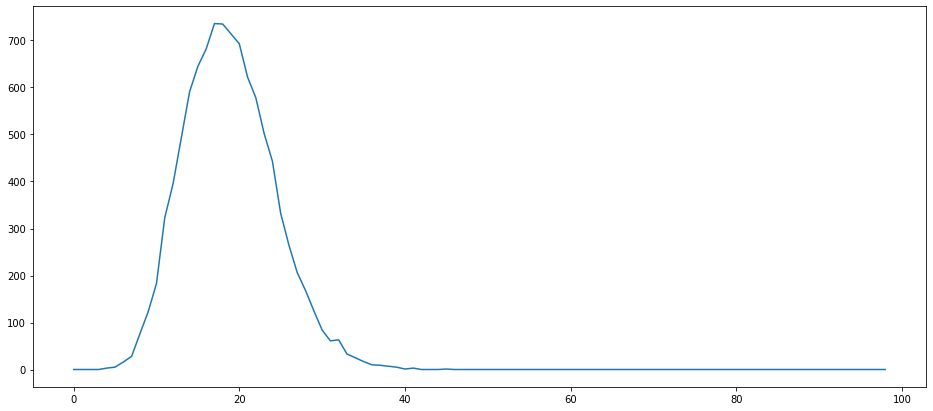

In [49]:
plt.plot(prior_counts)

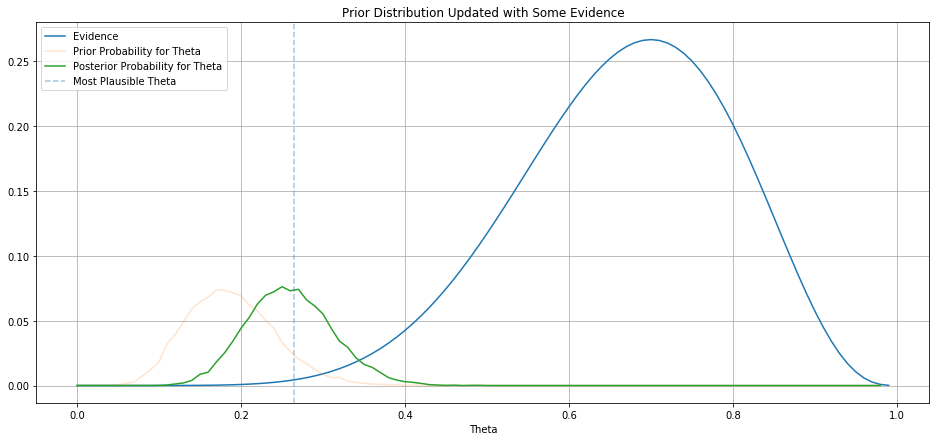

In [40]:
#plot
#plot the histogram of click through rates
plt.rcParams['figure.figsize'] = (16, 7)

f, ax = plt.subplots(1)
ax.plot(possible_theta_values, likelihoods)
ax.plot(bins[:-1],prior_counts_norm, alpha = .2)
ax.plot(bins[:-1],posterior_counts)
ax.axvline(most_plausible_theta, linestyle = "--", alpha = .4)
line1, line2, line3, line4 = ax.lines
ax.legend((line1, line2, line3, line4), ('Evidence'
                                         , 'Prior Probability for Theta'
                                         , 'Posterior Probability for Theta'
                                         , 'Most Plausible Theta'
                                        ), loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid()
ax.set_title("Prior Distribution Updated with Some Evidence")
plt.show()

100

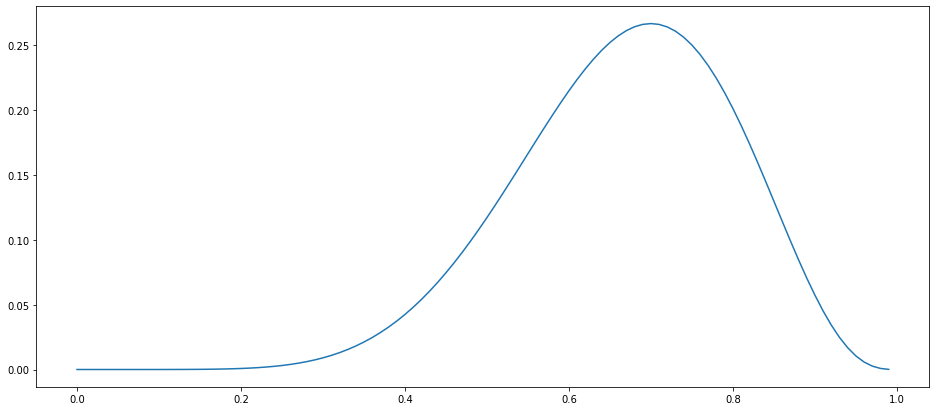

In [55]:
f, ax = plt.subplots(1)
ax.plot(possible_theta_values, likelihoods)

len(likelihoods)
#ax.plot(bins,prior_counts_norm, alpha = .2)


### Introduction-to-bayesian-inference-prior-distribution-updated-with-some-evidence

Now that we have a full distribution for the probability of various values of θ, we can take the mean of the distribution as our most plausible value for θ, which is about 0.27.

The data has caused us to believe that the true click-through rate is higher than we originally thought, but far lower than the 0.7 click-through rate observed so far from the facebook-yellow-dress campaign. 

Why is this the case? Note how wide our likelihood function is; it's telling us that there is a wide range of values of θ under which our data is likely. If the range of values under which the data were plausible were narrower, then our posterior would have shifted further. 

### Intuition
See what happens to the posterior if we observed a 0.7 click-through rate from 10, 100, 1,000, and 10,000 impressions:

logp = -5.3618, ||grad|| = 4.4667: 100%|████████████████████████████████████████████████| 7/7 [00:00<00:00, 847.02it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 22000/22000 [00:42<00:00, 517.41draws/s]
logp = -61.328, ||grad|| = 50.217: 100%|████████████████████████████████████████████████| 7/7 [00:00<00:00, 749.21it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 22000/22000 [00:43<00:00, 508.32draws/s]
logp = -610.91, ||grad|| = 507.72: 100%|████████████████████████████████████████████████| 8/8 [00:00<00:00, 704.14it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior]
S

NameError: name 'xrange' is not defined

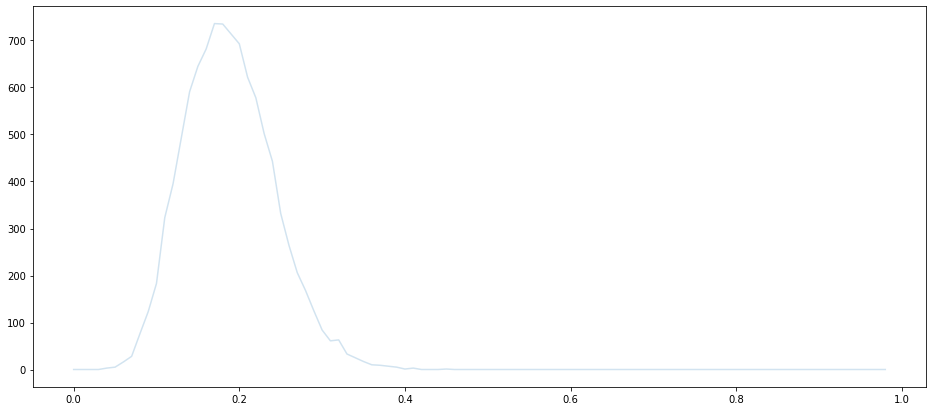

In [57]:
#create our data:
traces = {}
for ad_impressions in [10, 100, 1000, 10000]: 
#maintaining observed CTR of 0.7
    clicks = np.array([ctr * ad_impressions])
    #re-estimate the posterior for                  
    impressions = np.array([ad_impressions])
    #increasing numbers of impressions
    with pm.Model() as model:                           
        theta_prior = pm.Beta('prior', 11.5, 48.5)      
        observations = pm.Binomial('obs',n = impressions
                                   , p = theta_prior
                                   , observed = clicks) 
        start = pm.find_MAP()                           
        #step = pm.NUTS(state=start)                     
        trace = pm.sample(5000
                          , start=start
                          , progressbar=True) 
        
        traces[ad_impressions] = trace
        

f, ax = plt.subplots(1)
ax.plot(bins[:-1],prior_counts, alpha = .2)

counts = {}
for ad_impressions in [10, 100, 1000, 10000]:
    trace = traces[ad_impressions]
    posterior_counts, posterior_bins = np.histogram(trace['prior'], bins=[j/100. for j in range(100)])
    posterior_counts = posterior_counts / float(len(trace))
    ax.plot(bins[:-1], posterior_counts)
line0, line1, line2, line3, line4 = ax.lines
ax.legend((line0, line1, line2, line3, line4), ('Prior Distribution'
                                                ,'Posterior after 10 Impressions'
                                                , 'Posterior after 100 Impressions'
                                                , 'Posterior after 1000 Impressions'
                                                ,'Posterior after 10000 Impressions'))
ax.set_xlabel("Theta")
ax.axvline(ctr, linestyle = "--", alpha = .5)
ax.grid()
ax.set_ylabel("Probability of Theta")
ax.set_title("Posterior Shifts as Weight of Evidence Increases")
plt.show()
 